# Assignment 3: Policy Gradients (DDPG and REINFORCE)

Name:David Orozco

ID: A12054079

# Background
This exercise requires you to solve various continous control problems in OpenAI-Gym.  

DDPG is policy gradient actor critic method for continous control which is off policy. It tackles the curse of dimensionality / loss of performance faced when discretizing a continous action domain. DDPG uses similiar "tricks" as DQN to improve the stability of training, including a replay buffer and target networks.

Furthermore, you will implement REINFORCE for discrete and continous environments, and as a bonus compare the sample efficiency and performance with DQN and DDPG.


### DDPG paper: https://arxiv.org/pdf/1509.02971.pdf

### Environments:

#### InvertedPendulum-v2 environment:
<img src="inverted_pendulum.png" width="300">

#### Pendulum-v0 environment:
<img src="pendulum.png" width="300">

#### Halfcheetah-v2 environment:
<img src="half_cheetah.png" width="300">



### Setup environment for Actor Critic
- inline plotting
- gym
- directory for logging videos

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time
#environment
import gym
import statistics
#pytorch
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


logging_interval = 100
animate_interval = logging_interval
logdir='./DDPG/'


### Set up gym environment
The code below does the following for you:
- Wrap environment, log videos, setup CUDA variables (if GPU is available)
- Record action and observation space dimensions
- Fix random seed for determinisitic training

In [2]:
envName = 'cheetah'
VISUALIZE = False
SEED = 0
MAX_PATH_LENGTH = 500
NUM_EPISODES = 12000
GAMMA=0.99
BATCH_SIZE = 128

# Environments to be tested on
if envName == 'inverted pendulum':
    env_name = 'InvertedPendulum-v1'
elif envName == 'pendulum':
    env_name = 'Pendulum-v0'
elif envName =='cheetah':
    env_name = 'HalfCheetah-v1' 
elif envName == 'cartpole':
    env_name='CartPole-v0'
else:
    env_name = envName
    
print("Using ENV: "+env_name)
# wrap gym to save videos
envOriginal = gym.make(env_name)
env=envOriginal
if VISUALIZE:
    if not os.path.exists(logdir):
        os.mkdir(logdir)
    env = gym.wrappers.Monitor(env, logdir, force=True, video_callable=lambda episode_id: episode_id%logging_interval==0)
env._max_episodes_steps = MAX_PATH_LENGTH

# check observation and action space
discrete = isinstance(env.action_space, gym.spaces.Discrete)
obs_dim = env.observation_space.shape[0]

if discrete:
    act_dim = int(env.action_space.n /2)
else:
    act_dim = env.action_space.shape[0]
print ("obs space: "+str(obs_dim))
print("act dim: "+str(act_dim))
#print (env.action_space.high)
if discrete:
    print("This is a discrete action space, probably not the right algorithm to use")
print((env.action_space.sample()))
env.reset()
env.step(env.action_space.sample())
# set random seeds
torch.manual_seed(SEED)
np.random.seed(SEED)

# make variable types for automatic setting to GPU or CPU, depending on GPU availability
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor


[2018-05-30 20:29:37,368] Making new env: HalfCheetah-v1


Using ENV: HalfCheetah-v1
obs space: 17
act dim: 6
[ 0.09762701  0.43037873  0.20552675  0.08976637 -0.1526904   0.29178823]


### Demonstrate your understanding of the simulation:
For the environments mentioned above ('Pendulum-v0', 'HalfCheetah-v2', 'InvertedPendulum-v2'),
- describe the reward system
- describe the each state variable (observation space)
- describe the action space
- when is the environment considered "solved"?

Ans: For 'Half Cheetah v1' the reward system is based both on the energy used to move the cheetah (i.e. torque applied is negative reward) and positive reward is the speed at which the cheetah moves forward. The observation space is 17 variables which represent the joints position, velocity(slider), angle(hinge), and angular velocity (hinge). The action space is a 6 dimensional vector that represents the actuator torques that act on the hinge joints of the cheetah. (3 for the front 3 joints, and 3 for the back 3 joints). The environment is done when the cheetah reaches a time limit of 1000.

For 'Pendulum v1' there is one dimension for action space which is a continuous value ranging from -2 to 2 and represents the joint effort applied to the pendelum. There is 3 dimensional observation space which represents functions of the theta (pendulum angle) cos(thet),sin(thet)..etc. This is a continuous state space as we would expect. The reward system is highest for an angle of theta = 0 (upright pendulum), thus we want to remain in this position. There is no specific termination condition since it is a time dependent termination.

For 'InvertedPendulum v1' there is a 4 dimensional observation space which is similar to cartpole, representing angles and velocities.  The action space is one dimensional which is a continous number repesenting the cart moving left or right. The game is over when the cart leaves the frame or the pole falls below a certain angle. Reward is the same as cart pole which is to have the pole up at an angle of zero.

### Implement an action normalization class:
To train across various environments, it is useful to normalize action inputs and outputs between [-1, 1]. This class should take in actions and implement forward and reverse functions to map actions between [-1, 1] and [action_space.low, action_space.high].

Using the following gym wrapper, implement this class.
- https://github.com/openai/gym/blob/78c416ef7bc829ce55b404b6604641ba0cf47d10/gym/core.py
- i.e. we are overriding the outputs scale of actions. 

In [3]:
class NormalizeAction(gym.ActionWrapper):
    def action(self, action):
        #tanh outputs (-1,1) from tanh, need to be [action_space.low, action_space.high]
        Range = (env.action_space.high-env.action_space.low)
        action = ((action + 1.)*(Range/2.))+env.action_space.low
      
        return action
    def reverse_action(self, action):
        #reverse of that above
        Range = (env.action_space.high-env.action_space.low)
        action = (action - env.action_space.low)/Range
        action = (action*2.)-1.
        return action


# DDPG

### Write a weight syncing function
In contrast to DQN, DDPG uses soft weight sychronization. At each time step following training, the actor and critic target network weights are updated to track the rollout networks. 
- target_network.weights <= target_network.weights \* (1 - tau) + source_network.weights \* (tau)

In [4]:
def weightSync(target_model, source_model, tau = 0.001):
    for parameter_target, parameter_source in zip(target_model.parameters(), source_model.parameters()):
        parameter_target.data.copy_((1 - tau) * parameter_target.data + tau * parameter_source.data)

### Write a Replay class that includes all the functionality of a replay buffer
DDPG is an off policy actor-critic method and an identical replay buffer to that used for the previous assignment is applicable here as well (do not include the generate_minibatch method in your Replay class this time). Like before, your constructor for Replay should create an initial buffer of size 1000 when you instantiate it.

The replay buffer should kept to some maximum size (60000), allow adding of samples and returning of samples at random from the buffer. Each sample (or experience) is formed as (state, action, reward, next_state, done). 

In [5]:
class Replay:
    
    def __init__(self,max_size=60000):
        self.max_size = max_size
        self.replay_buffer = []
        
    def initialize(self,env,init_length = 1000):
        observation = env.reset()
        for steps in range(init_length):
            #time.sleep(0.05)
            #env.render()
            experience = []
            observation = np.reshape(observation, [1, observation.size])
            #append state
            experience.append(observation)
            action = env.action_space.sample()
            #append random action
            
            
            observation,reward,done,_= env.step(action)
            
            if type(action) != int:
                action = np.reshape(action, [1, action.size])
            experience.append(action)
            #append reward
            experience.append(reward)
            observation = np.reshape(observation, [1, observation.size])
            #append next state
            experience.append(observation)
            #append done flag
            experience.append(done)
            self.replay_buffer.append(experience)
           
            if done == True:
                observation = env.reset()
                
    def add_memory(self,memory):
        if len(self.replay_buffer) > self.max_size:
            self.replay_buffer.pop(0)
            self.replay_buffer.append(memory)
        else:
            self.replay_buffer.append(memory)
        
    def return_samples(self,numSamples):
        batch = random.sample(self.replay_buffer,numSamples)
        return batch
        

### Write an Ornstein Uhlenbeck process class for exploration noise
The proccess is described here:
- https://en.wikipedia.org/wiki/Ornstein–Uhlenbeck_process
- http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab

You should implement:
- a step / sample method
- reset method

Use theta = 0.15, mu = 0, sigma = 0.3, dt = 0.01

In [6]:
class OrnsteinUhlenbeckProcess():
    def __init__(self,dimension):
        #piazza values: theta=0.25, mu=0, sigma=0.05, dt=0.01
        self.th = 0.25
        self.mu = 0
        self.sig = 0.05
        self.dt = 0.01
        self.dimension = dimension
        self.reset()
        
    def reset(self):
        # Time vector
        self.x = np.zeros((1,self.dimension)) # Allocate output vector, set initial condition
        # Set random seed ?
    def step(self):
        self.x = self.x+self.th*(self.mu-self.x)*self.dt+self.sig*np.sqrt(self.dt)*np.random.normal(self.mu, self.sig, (1,self.dimension) )
        return self.x


### Write a Deep Neural Network class that creates a dense network of a desired architecture for actor and critic networks


#### Actor
- input and hidden layer activation function: ReLU

- output activation function: Tanh

- hidden_state sizes: 400

- state and action sizes: variable

- number of hidden layers: 2

- batch normalization applied to all hidden layers

- weight initialization: normal distribution with small variance. 

#### Critic
- input and hidden layer activation function: ReLU

- output activation function: None

- hidden_state sizes: 300, 300 + action size

- state and action sizes: variable

- number of hidden layers: 2

- batch normalization applied to all hidden layers prior to the action input

- weight initialization: normal distribution with small variance.

Good baselines can be found in the paper.

In [7]:
# ----------------------------------------------------
# actor model, MLP
# ----------------------------------------------------
# 2 hidden layers, 400 units per layer, tanh output to bound outputs between -1 and 1

class actor(nn.Module):
    def __init__(self,input_size, output_size,use_batchNorm = True):
        super(actor, self).__init__()
        self.hidden_layers = 2
        self.hidden_units = 400
        
        self.fc1 = nn.Linear(input_size, self.hidden_units,bias=True)
        #torch.nn.init.normal(self.fc1.weight,0,0.1)
        self.bn1 = nn.BatchNorm1d(self.hidden_units)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        
        self.fc2 = nn.Linear(self.hidden_units, self.hidden_units,bias=True)
        #torch.nn.init.normal(self.fc2.weight,0,0.1)
        self.bn2 = nn.BatchNorm1d(self.hidden_units)
        torch.nn.init.xavier_uniform(self.fc2.weight)
        
        self.fc3 = nn.Linear(self.hidden_units, output_size,bias=True)
        #torch.nn.init.normal(self.fc3.weight,0,0.1)
        torch.nn.init.xavier_uniform(self.fc3.weight)
        self.use_BN = use_batchNorm
        
        
    def forward(self, x):
        if self.use_BN:
            x = F.relu(self.bn1(self.fc1(x)))
            x = F.relu(self.bn2(self.fc2(x)))
            x = F.tanh(self.fc3(x))
        else:
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = F.tanh(self.fc3(x))
        #x = self.fc3(x)
        return x
        
        
# ----------------------------------------------------
# critic model, MLP
# ----------------------------------------------------
# 2 hidden layers, 300 units per layer, ouputs rewards therefore unbounded
# Action not to be included until 2nd layer of critic (from paper). Make sure to formulate your critic.forward() accordingly

class critic(nn.Module):
    def __init__(self,input_size,action_size, output_size,use_batchNorm = True):
        super(critic, self).__init__()
        self.hidden_layers = 2
        self.hidden_units = 300
        
        self.fc1 = nn.Linear(input_size, self.hidden_units,bias=True)
        #torch.nn.init.normal(self.fc1.weight,0,0.1)
        self.bn1 = nn.BatchNorm1d(self.hidden_units)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        
        self.fc2 = nn.Linear(self.hidden_units+action_size, self.hidden_units,bias=True)
        #torch.nn.init.normal(self.fc2.weight,0,0.1)
        torch.nn.init.xavier_uniform(self.fc2.weight)
        
        self.fc3 = nn.Linear(self.hidden_units, output_size,bias=True)
        torch.nn.init.normal(self.fc3.weight,0,0.1)
        #torch.nn.init.xavier_uniform(self.fc3.weight)
        self.use_BN = use_batchNorm
        
        
    def forward(self, x, action):
        if self.use_BN:
            x = F.relu(self.bn1(self.fc1(x)))
            x = torch.cat((x,action),1)
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
        else:
            x = F.relu(self.fc1(x))
            x = torch.cat((x,action),1)
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
        return x

### Define DDPG class to encapsulate definition, rollouts, and training

- gamma = 0.99

- actor_lr = 1e-4

- critic_lr = 1e-3

- critic l2 regularization = 1e-2

- noise decay

- noise class

- batch_size = 128

- optimizer: Adam

- loss (critic): mse

Furthermore, you can experiment with action versus parameter space noise. The standard implimentation works with action space noise, howeve parameter space noise has shown to produce excellent results.


In [8]:
#(state, action, reward, next_state, done)
class DDPG:
    def __init__(self, obs_dim, act_dim, critic_lr = 1e-3, actor_lr = 1e-4, gamma = 0.99, batch_size = 128,use_BN = True):
        
        self.gamma = GAMMA
        self.batch_size = BATCH_SIZE
        
        # actor
        self.actor = actor(input_size = obs_dim, output_size = act_dim, use_batchNorm = use_BN).type(FloatTensor)
        self.actor_target = actor(input_size = obs_dim, output_size = act_dim,use_batchNorm = use_BN).type(FloatTensor)
        self.actor_target.load_state_dict(self.actor.state_dict())

        # critic
        self.critic = critic(input_size = obs_dim, action_size = act_dim, output_size = 1,use_batchNorm = use_BN).type(FloatTensor)
        self.critic_target = critic(input_size = obs_dim, action_size = act_dim, output_size = 1,use_batchNorm = use_BN).type(FloatTensor)
        self.critic_target.load_state_dict(self.critic.state_dict())

        # optimizers
        self.optimizer_actor = torch.optim.Adam(self.actor.parameters(), lr = actor_lr)
        self.optimizer_critic = torch.optim.Adam(self.critic.parameters(), lr = critic_lr, weight_decay=1e-2)
        
        # critic loss
        self.critic_loss = nn.MSELoss()
        
        # noise
        self.noise = OrnsteinUhlenbeckProcess(dimension = act_dim)

        # replay buffer 
        self.replayBuffer = Replay()
        
        self.state_size = obs_dim
        self.action_size = act_dim
        self.gamma = gamma
        
    def train(self):
     
        # sample from Replay
        samples  = self.replayBuffer.return_samples(BATCH_SIZE)
        # update critic (create target for Q function)
        rewards = np.zeros((len(samples),1))
        next_states = np.zeros((len(samples),self.state_size))
        current_states = np.zeros((len(samples),self.state_size))
        current_actions = np.zeros((len(samples),self.action_size))
        
        for index,sample in enumerate(samples):
            rewards[index] = sample[2] #reward
            next_states[index,:] = sample[3]
            current_states[index,:] = sample[0]
            current_actions[index,:] = sample[1]
            
        current_states = Variable(torch.from_numpy(current_states).float().cuda())
        current_actions = Variable(torch.from_numpy(current_actions).float().cuda())
        nextState = Variable(torch.from_numpy(next_states).float().cuda())
        
        actions = self.actor_target(nextState)
        critic_targets=rewards+(self.gamma*self.critic_target(nextState,actions).cpu().detach().numpy())
        # critic optimizer and backprop step (feed in target and predicted values to self.critic_loss)
        #print(np.shape(critic_targets))
        
        target =  Variable(torch.from_numpy(critic_targets).float().cuda())
        output = self.critic(current_states,current_actions)
        loss = self.critic_loss(output,target)
        self.optimizer_critic.zero_grad()
        loss.backward()
        self.optimizer_critic.step()
        # update actor (formulate the loss wrt which actor is updated)
        actor_loss = -torch.mean(self.critic(current_states,self.actor(current_states)))
        # actor optimizer and backprop step (loss_actor.backward())
        self.optimizer_actor.zero_grad()
        actor_loss.backward()
        self.optimizer_actor.step()
        # sychronize target network with fast moving one
        weightSync(self.critic_target, self.critic)
        weightSync(self.actor_target, self.actor)
        

### Create an instance of your DDPG object
- Print network architectures, confirm they are correct

In [9]:
if envName == 'pendulum':
    use_batchNorm = False
    print('not using BN')
else:
    use_batchNorm = True
    
ddpg = DDPG(obs_dim = obs_dim, act_dim = act_dim, use_BN = use_batchNorm)
ddpg.replayBuffer.initialize(env)
print(ddpg.actor)
print(ddpg.critic)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


actor(
  (fc1): Linear(in_features=17, out_features=400, bias=True)
  (bn1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=400, out_features=400, bias=True)
  (bn2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=400, out_features=6, bias=True)
)
critic(
  (fc1): Linear(in_features=17, out_features=300, bias=True)
  (bn1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=306, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:60: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


In [21]:
VISUALIZE = False
SEED = 0
MAX_PATH_LENGTH = 500
NUM_EPISODES = 20000
GAMMA=0.99
BATCH_SIZE = 128

# Environments to be tested on
if envName == 'inverted pendulum':
    env_name = 'InvertedPendulum-v1'
elif envName == 'pendulum':
    env_name = 'Pendulum-v0'
elif envName == 'chetah':
    env_name = 'HalfCheetah-v1' 
elif envName == 'cartpole':
    env_name='CartPole-v0'
    
print("Using ENV: "+env_name)
# wrap gym to save videos
envOriginal = gym.make(env_name)
env=envOriginal
if VISUALIZE:
    if not os.path.exists(logdir):
        os.mkdir(logdir)
    env = gym.wrappers.Monitor(env, logdir, force=True, video_callable=lambda episode_id: episode_id%logging_interval==0)
env._max_episodes_steps = MAX_PATH_LENGTH

# check observation and action space
discrete = isinstance(env.action_space, gym.spaces.Discrete)
obs_dim = env.observation_space.shape[0]
act_dim = int(env.action_space.n) if discrete else env.action_space.shape[0]
print ("obs space: "+str(obs_dim))
print("act dim: "+str(act_dim))
#print (env.action_space.high)
if discrete:
    print("This is a discrete action space, probably not the right algorithm to use")
print((env.action_space.sample()))
#env.reset()
#env.step(env.action_space.sample())
# set random seeds
torch.manual_seed(SEED)
np.random.seed(SEED)

# make variable types for automatic setting to GPU or CPU, depending on GPU availability
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

[2018-05-30 20:40:50,487] Making new env: HalfCheetah-v1


Using ENV: HalfCheetah-v1
obs space: 17
act dim: 6
[-0.08160615  0.88097931 -0.29010504 -0.65402865 -0.05581189  0.30518324]


### Train DDPG on different environments
Early stopping conditions:
- avg_val > 500 for "InvertedPendulum" 
- avg_val > -150 for "Pendulum" 
- avg_val > 1500 for "HalfCheetah" 



In [22]:
import pickle
if not discrete:
    env = NormalizeAction(env) # remap action values for the environment
avg_val = 0

#for plotting
running_rewards_ddpg = []
average_rewards_ddpg = []
step_list_ddpg = []
step_counter = 0
done_recording = False
# set term_condition for early stopping according to environment being used
if envName =='pendulum':
    term_condition = -150 # Pendulum
elif envName == 'inverted pendulum':
    term_condition = 500
elif envName == 'cheetah':
    term_condition = 1500
elif envName == 'cartpole':
    term_condition = 199
else:
    term_condition = 0
    
all_data = []
for itr in range(NUM_EPISODES):
    observation  = env.reset() # get initial state
    #print(observation)
    animate_this_episode = (itr % animate_interval == 0) and VISUALIZE
    ddpg.noise.reset()
    total_reward = 0
    
    #print(ddpg.replayBuffer.replay_buffer)
    #print(data1)
    while True:
        memory = []
        observation = np.reshape(observation, [1, observation.size])
        #all_data.append(observation.tolist())
        memory.append(observation)
        if animate_this_episode:
                env.render()
                time.sleep(0.05)
                if avg_val > term_condition:
                    done_recording = True

        # use actor to get action, add ddpg.noise.step() to action
        ddpg.actor.eval()
        action = ddpg.actor(Variable(torch.from_numpy(observation).float().cuda()))
        ddpg.actor.train()
        #print(action.cpu().detach().numpy())
        noise = ddpg.noise.step()
        #print(noise)
        action = action.cpu().detach().numpy()+noise
        action = action[0]
        
        observation,reward,done,dual_rewards = env.step(action)
        if type(action) != int:
            action = np.reshape(action, [1,action.size])
        memory.append(action)
        
        memory.append(reward)
        observation = np.reshape(observation, [1, observation.size])
        memory.append(observation)
        memory.append(done)
        ddpg.replayBuffer.add_memory(memory)
        memory.append(env.env.env.data.qpos.flatten())
        memory.append(env.env.env.data.qvel.flatten())
        memory[0] = memory[0][0].tolist()
        memory[2] = float(memory[2])
        memory[1] = memory[1][0].tolist()
        memory[3] = memory[3][0].tolist()
        memory[4] = float(memory[4])
        memory[5] = memory[5].tolist()
        memory[6] = memory[6].tolist()

        all_data.append(memory)
        total_reward += reward
        #print(observation)
        # remember to put NN in eval mode while testing (to deal with BatchNorm layers) and put it back 
        # to train mode after you're done getting the action
                
        # step action, get next state, reward, done (keep track of total_reward)
        # populate ddpg.replayBuffer
        
        ddpg.train()
        
        step_counter += 1
        #if(step_counter%100 == 0):
            #print(step_counter)
        if done:
            break
    print("Itr: "+str(itr)+"count: "+str(step_counter))

    if avg_val > term_condition and itr > 100 and (done_recording or not VISUALIZE) and len(all_data) >300000:
        print('breaking early : '+str(avg_val))
        break

    running_rewards_ddpg.append(total_reward) # return of this episode
    average_rewards_ddpg.append(avg_val)
    step_list_ddpg.append(step_counter)
    if itr == 0:
        avg_val = running_rewards_ddpg[-1]
    else:
        avg_val = avg_val * 0.95 + 0.05*running_rewards_ddpg[-1]
    print("Average value: {} Reward:{} for episode: {}".format(avg_val,running_rewards_ddpg[-1],itr))

running_rewards_ddpg.append(total_reward) # return of this episode
average_rewards_ddpg.append(avg_val)
step_list_ddpg.append(step_counter)

    
output = open(env_name+'.pickle', 'wb')
pickle.dump(all_data, output)
output.close()
avg_val = avg_val * 0.95 + 0.05*running_rewards_ddpg[-1]
print("Average value: {} for episode: {}".format(avg_val,itr))

Itr: 0count: 1000
Average value: 125.1727260257824 Reward:125.1727260257824 for episode: 0
Itr: 1count: 2000
Average value: 122.67455589478075 Reward:75.20932340574979 for episode: 1
Itr: 2count: 3000
Average value: 121.19470787097057 Reward:93.07759541857746 for episode: 2
Itr: 3count: 4000
Average value: 119.12591222587896 Reward:79.8187949691386 for episode: 3
Itr: 4count: 5000
Average value: 120.49176202260641 Reward:146.4429081604279 for episode: 4
Itr: 5count: 6000
Average value: 121.53672066452363 Reward:141.39093486095067 for episode: 5
Itr: 6count: 7000
Average value: 124.71882851716774 Reward:185.17887771740595 for episode: 6
Itr: 7count: 8000
Average value: 128.76380579798038 Reward:205.6183741334207 for episode: 7
Itr: 8count: 9000
Average value: 132.7242683874216 Reward:207.97305758680494 for episode: 8
Itr: 9count: 10000
Average value: 135.13446787126935 Reward:180.92825806437688 for episode: 9
Itr: 10count: 11000
Average value: 140.46012434503638 Reward:241.6475973466098

Itr: 87count: 88000
Average value: 395.13109268960324 Reward:838.1342423138254 for episode: 87
Itr: 88count: 89000
Average value: 418.621499817043 Reward:864.9392352383986 for episode: 88
Itr: 89count: 90000
Average value: 442.0803348171973 Reward:887.7981998201292 for episode: 89
Itr: 90count: 91000
Average value: 458.8302046935579 Reward:777.0777323444099 for episode: 90
Itr: 91count: 92000
Average value: 484.8941859857293 Reward:980.1098305369859 for episode: 91
Itr: 92count: 93000
Average value: 504.99824516512894 Reward:886.9753695737234 for episode: 92
Itr: 93count: 94000
Average value: 524.6409130055588 Reward:897.8516019737274 for episode: 93
Itr: 94count: 95000
Average value: 540.4959554733454 Reward:841.7417623612906 for episode: 94
Itr: 95count: 96000
Average value: 557.345538208973 Reward:877.4876101858995 for episode: 95
Itr: 96count: 97000
Average value: 573.1712944745365 Reward:873.8606635202425 for episode: 96
Itr: 97count: 98000
Average value: 585.6737680117501 Reward:

Itr: 172count: 173000
Average value: 1411.9167520970468 Reward:1705.7952269304521 for episode: 172
Itr: 173count: 174000
Average value: 1436.2237362287754 Reward:1898.0564347316197 for episode: 173
Itr: 174count: 175000
Average value: 1456.3274677031445 Reward:1838.2983657161603 for episode: 174
Itr: 175count: 176000
Average value: 1480.3944473306328 Reward:1937.667060252909 for episode: 175
Itr: 176count: 177000
Average value: 1506.4241443520316 Reward:2000.9883877586085 for episode: 176
Itr: 177count: 178000
Average value: 1526.7289029795584 Reward:1912.5193169025677 for episode: 177
Itr: 178count: 179000
Average value: 1555.7313032529128 Reward:2106.776908446643 for episode: 178
Itr: 179count: 180000
Average value: 1580.3492899234068 Reward:2048.091036662795 for episode: 179
Itr: 180count: 181000
Average value: 1605.0672887423868 Reward:2074.7092663030066 for episode: 180
Itr: 181count: 182000
Average value: 1628.0604648537658 Reward:2064.930810969967 for episode: 181
Itr: 182count:

Itr: 256count: 257000
Average value: 1768.031780317606 Reward:-322.83620208047256 for episode: 256
Itr: 257count: 258000
Average value: 1664.2360671503761 Reward:-307.8824830269944 for episode: 257
Itr: 258count: 259000
Average value: 1694.3908730412272 Reward:2267.332184967399 for episode: 258
Itr: 259count: 260000
Average value: 1731.3484133092466 Reward:2433.5416784016143 for episode: 259
Itr: 260count: 261000
Average value: 1770.5652854937498 Reward:2515.6858569993115 for episode: 260
Itr: 261count: 262000
Average value: 1812.506185721628 Reward:2609.383290051319 for episode: 261
Itr: 262count: 263000
Average value: 1853.1338535043647 Reward:2625.0595413763645 for episode: 262
Itr: 263count: 264000
Average value: 1891.8349854681821 Reward:2627.156492780712 for episode: 263
Itr: 264count: 265000
Average value: 1922.0955994226756 Reward:2497.047264558057 for episode: 264
Itr: 265count: 266000
Average value: 1957.3960253904695 Reward:2628.1041187785545 for episode: 265
Itr: 266count: 

In [26]:
pkl_file = open('cheetah.pickle', 'rb')
data1 = pickle.load(pkl_file)

#print(data1[0])
print(len(data1))
episodes = []
ep = []
rewards = []
reward = 0
for i in range(len(data1)):
    step = data1[i]
    done = step[4]
    reward+=step[2]
    if not done:
        ep.append(step)
    else:
        episodes.append(ep)
        #print(len(ep))
        print(reward)
        ep = []
        rewards.append(reward)
        reward = 0
        
print(len(episodes))
output = open('cheetah_episodes.pickle', 'wb')
pickle.dump(episodes, output)
output.close()
    
output = open('cheetah_total_rewards.pickle', 'wb')
pickle.dump(rewards, output)
output.close()

60001
721.0134550147966
1039.5159081613788
1092.1830903747061
1175.6394479599294
1153.0103731186675
1206.2361348116672
393.10217404380825
-185.85947665950923
194.19169841149485
-304.38367401815236
-333.2916427067197
-435.7715750947921
466.54060598457363
773.7810934777822
1338.942697129661
1255.580222221099
1236.3676815703336
1402.1569857369416
1360.9994564209903
1425.8726740016975
1322.2015633700269
1465.9655319074361
1435.2900947427784
1397.9494287783452
1412.4005923840487
1304.9404091145698
1493.5653413959626
1374.4205725825095
1411.6986383238634
1333.6056517752306
1408.8112799113655
1551.780303745348
1789.453449630853
1494.412438670516
1633.3303404994024
1853.8809931611922
1652.700899328849
1848.471190839882
1879.39990733072
1851.8979698227647
1849.6658780369662
1912.726178496898
1876.846889546164
1862.795475403603
1900.4779716792548
1657.7836462771272
1702.7632221107838
1865.3299937727909
1798.2080830165062
1855.7041320340627
1759.8814376715354
1765.6059903943444
1963.0578515463285

## Plot rewards over multiple training runs 
This is provided to generate and plot results for you.

In [12]:
def numpy_ewma_vectorized_v2(data, window):

    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))

    scale_arr = 1/pows[:-1]
    offset = data[0]*pows[1:]
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out



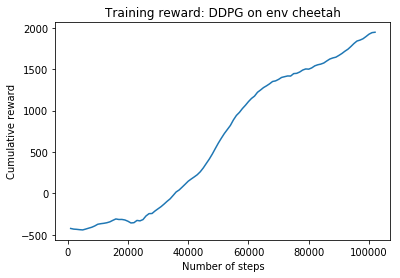

In [13]:

plt.figure()
out = numpy_ewma_vectorized_v2(np.array(running_rewards_ddpg),20)
#out = np.array(average_rew)
step_list_ddpg = np.array(step_list_ddpg)
plt.plot(step_list_ddpg, out)
plt.title('Training reward: DDPG on env '+envName)
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
plt.show()

# REINFORCE

In this section you will implement REINFORCE, with modifications for batch training. It will be for use on both discrete and continous action spaces.

## Policy Parametrization

Define a MLP which outputs a distribution over the action preferences given input state. For the discrete case, the MLP outputs the likelihood of each action (softmax) while for the continuous case, the output is the mean and standard deviation parametrizing the normal distribution from which the action is sampled.



In [14]:
# ----------------------------------------------------
# Policy parametrizing model, MLP
# ----------------------------------------------------
# 1 or 2 hidden layers with a small number of units per layer (similar to DQN)
# use ReLU for hidden layer activations
# softmax as activation for output if discrete actions, linear for continuous control
# for the continuous case, output_dim=2*act_dim (each act_dim gets a mean and std_dev)

class mlp(nn.Module):
    def __init__(self,input_size, output_size,discrete):
        super(mlp, self).__init__()
        self.hidden_layers = 2
        self.hidden_units = 40
        
        self.fc1 = nn.Linear(input_size, self.hidden_units,bias=True)
        #torch.nn.init.normal(self.fc1.weight,0,0.1)
        #self.bn1 = nn.BatchNorm1d(self.hidden_units)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        
        self.fc2 = nn.Linear(self.hidden_units, self.hidden_units,bias=True)
        #torch.nn.init.normal(self.fc2.weight,0,0.1)
        #self.bn2 = nn.BatchNorm1d(self.hidden_units)
        torch.nn.init.xavier_uniform(self.fc2.weight)
        if not discrete:
            self.fc3 = nn.Linear(self.hidden_units, 2*output_size,bias=True)
        elif discrete:
            self.fc3 = nn.Linear(self.hidden_units, output_size,bias=True)
        #torch.nn.init.normal(self.fc3.weight,0,0.1)
        torch.nn.init.xavier_uniform(self.fc3.weight)
        self.discrete = discrete
        self.output_size = output_size
        self.soft = nn.Softmax()
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        if self.discrete:
            return self.soft(x)
        else:
            return torch.split(x, self.output_size, dim=1)

Define a function that samples an action from the policy distribtion parameters obtained as output of the MLP. The function should return the action and the log-probability (log_odds) of taking that action. 

In [15]:
def sample_action(logit, discrete):
    # logit is the output of the softmax/linear layer
    # discrete is a flag for the environment type
    # Hint: use Categorical and Normal from torch.distributions to sample action and get the log-probability
    # Note that log_probability in this case translates to ln(\pi(a|s)) 
    if discrete:
        m = torch.distributions.categorical.Categorical(logit)
        action = m.sample()
        #next_state, reward = env.step(action)
        #loss = -m.log_prob(action) * reward
        #loss.backward()
        log_odds = m.log_prob(action)
    else:
        #print(logit)
        m = torch.distributions.normal.Normal(logit[0][0],logit[1][0])
        action = m.sample()
        log_odds = m.log_prob(action)
    return action, log_odds


Create a function update_policy that defines the loss function and updates the MLP according to the REINFORCE update rule (ref. slide 24 of Lec 7 or page 330 of Sutton and Barto (2018)). The update algorithm to be used below is slightly different: instead of updating the network at every time-step, we take the gradient of the loss averaged over a batch of timesteps (this is to make SGD more stable). We also use a baseline to reduce variance. 

The discount factor is set as 1 here. 


In [16]:
def update_policy(paths, net):
    # paths: a list of paths (complete episodes, used to calculate return at each time step)
    # net: MLP object

    
    num_paths = len(paths)
    rew_cums = []
    log_odds = []
    gamma = 1
    for path in paths:
         # rew_cums should record return at each time step for each path 
        backwards = []
        reward_sum = 0
        rewards = path['reward']
        for reward in reversed(rewards):
            reward_sum  = gamma*reward_sum + reward
            backwards.append(reward_sum)
            
        rew_cums = rew_cums + backwards[::-1]
        log_odds = log_odds + path['log_odds']
         # log_odds should record log_odds obtained at each timestep of path
         # calculated as "reward to go"
    rew_cums = np.asarray(rew_cums) 
    rew_cums = torch.autograd.Variable(torch.from_numpy(rew_cums)).type(FloatTensor)
    rew_cums = (rew_cums - rew_cums.mean()) / (rew_cums.std() + 1e-5) # create baseline
  #
   # x = torch.from_numpy(rew_cums).float().cuda()
    #print(x.size())
    #print(len(log_odds))
    log_odds = torch.stack(log_odds).squeeze().type(FloatTensor)
    if len(log_odds.shape) > 1:
        log_odds = log_odds.sum(dim=1)
    loss = -1*torch.mean(torch.mul(rew_cums,log_odds))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # make log_odds, rew_cums each a vector
        
    # calculate policy loss and average over paths
    
    # take optimizer step
   

Set up environment and instantiate objects. Your algorithm is to be tested on one discrete and two continuous environments. 



In [17]:
# Select Environment

#discrete environment:
envName = 'cartpole'
# Environments to be tested on
if envName == 'inverted pendulum':
    env_name = 'InvertedPendulum-v1'
elif envName =='cheetah':
    env_name = 'HalfCheetah-v1' 
elif envName == 'cartpole':
    env_name='CartPole-v0'
print("Using ENV: "+env_name)



# Make the gym environment
env = gym.make(env_name)
visualize = True
animate=visualize

learning_rate = 1e-3

max_path_length=500
min_timesteps_per_batch = 2000

# Set random seeds
seed=0
torch.manual_seed(seed)
np.random.seed(seed)

# Saving parameters
logdir='./REINFORCE/'


if visualize:
    if not os.path.exists(logdir):
        os.mkdir(logdir)
    env = gym.wrappers.Monitor(env, logdir, force=True, video_callable=lambda episode_id: episode_id%animate_interval==0)
env._max_episodes_steps = min_timesteps_per_batch

# make variable types for automatic setting to GPU or CPU, depending on GPU availability
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

# Is this env continuous, or discrete?
discrete = isinstance(env.action_space, gym.spaces.Discrete)

# Get observation and action space dimensions
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n if discrete else env.action_space.shape[0]

# Maximum length for episodes
max_path_length = max_path_length or env.spec.max_episode_steps

# Make network object (remember to pass in appropriate flags for the type of action space in use)
# net = mlp(*args)
net = mlp(obs_dim,act_dim,discrete).type(FloatTensor)
# Make optimizer
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)



[2018-05-22 15:05:54,168] Making new env: CartPole-v0
[2018-05-22 15:05:54,184] Finished writing results. You can upload them to the scoreboard via gym.upload('/datasets/home/86/786/dorozco/DDPG')
[2018-05-22 15:05:54,193] Clearing 186 monitor files from previous run (because force=True was provided)


Using ENV: CartPole-v0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


## Run REINFORCE

Run REINFORCE for CartPole, InvertedPendulum, and HalfCheetah. 

[2018-05-22 15:05:54,638] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video000000.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
[2018-05-22 15:07:45,314] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video000100.mp4


Average reward: 22.0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
[2018-05-22 15:07:48,174] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video000200.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
[2018-05-22 15:07:51,493] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video000300.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
[2018-05-22 15:07:54,441] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video000400.mp4
/opt/conda/li

Average reward: 24.829477331492672


[2018-05-22 15:10:01,132] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video001000.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
[2018-05-22 15:10:03,955] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video001100.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
[2018-05-22 15:10:07,465] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video001200.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
[2018-05-22 1

Average reward: 34.90757720075424


[2018-05-22 15:12:12,456] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video001600.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
[2018-05-22 15:12:16,791] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video001700.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
[2018-05-22 15:12:20,267] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video001800.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
[2018-05-22 1

Average reward: 38.57328730008678


[2018-05-22 15:14:26,042] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video002200.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
[2018-05-22 15:14:32,022] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video002300.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
[2018-05-22 15:14:37,165] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video002400.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
[2018-05-22 1

Average reward: 46.20672716509851


[2018-05-22 15:16:41,312] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video002700.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
[2018-05-22 15:16:46,802] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video002800.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
[2018-05-22 15:16:53,609] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video002900.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
[2018-05-22 1

Average reward: 49.14166575098713


[2018-05-22 15:18:52,844] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video003100.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
[2018-05-22 15:18:58,620] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video003200.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
[2018-05-22 15:19:05,280] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video003300.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Average reward: 59.39971715980772


[2018-05-22 15:21:00,397] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video003400.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
[2018-05-22 15:21:07,771] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video003500.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
[2018-05-22 15:21:16,831] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video003600.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Average reward: 77.24735907375391


[2018-05-22 15:23:10,999] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video003700.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
[2018-05-22 15:23:19,881] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video003800.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
[2018-05-22 15:23:29,946] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video003900.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Average reward: 90.60875887744405


[2018-05-22 15:25:36,556] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video004000.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Average reward: 125.9066766938374


[2018-05-22 15:27:38,227] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video004100.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
[2018-05-22 15:27:54,650] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video004200.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Average reward: 141.56366297759556


[2018-05-22 15:30:02,334] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video004300.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Average reward: 150.5511148690984


[2018-05-22 15:32:07,758] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video004400.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
[2018-05-22 15:34:21,563] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video004500.mp4


Average reward: 163.50725522640732


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
[2018-05-22 15:34:42,693] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video004600.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Average reward: 175.5526013153595


[2018-05-22 15:36:57,769] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video004700.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Average reward: 174.59232551852065


[2018-05-22 15:39:13,867] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video004800.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Average reward: 183.02124470759472


[2018-05-22 15:41:32,350] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video004900.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Average reward: 184.1434755384446


[2018-05-22 15:43:46,291] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video005000.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Average reward: 190.2075738828497


[2018-05-22 15:46:06,472] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video005100.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Average reward: 194.13691275889937


[2018-05-22 15:48:20,757] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video005200.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
[2018-05-22 15:50:39,593] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video005300.mp4


Average reward: 196.29955309077576


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
[2018-05-22 15:51:22,775] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video005400.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Average reward: 193.88821748004594


[2018-05-22 15:53:18,535] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video005500.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Average reward: 192.645526290712


[2018-05-22 15:55:33,210] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video005600.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Average reward: 195.5966049215917


[2018-05-22 15:57:52,425] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video005700.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Average reward: 196.36648729703768


[2018-05-22 16:00:11,954] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video005800.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Average reward: 194.82432078977425


[2018-05-22 16:02:30,335] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video005900.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Average reward: 191.98953000731925


[2018-05-22 16:04:38,333] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video006000.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Average reward: 189.9070541447022


[2018-05-22 16:06:48,434] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video006100.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Average reward: 193.95698049070023


[2018-05-22 16:09:07,826] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video006200.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Average reward: 195.58182099524393


[2018-05-22 16:11:24,185] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video006300.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
[2018-05-22 16:12:18,676] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video006400.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Average reward: 197.35467302568503


[2018-05-22 16:14:04,566] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video006500.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Average reward: 197.55877002411387


[2018-05-22 16:16:24,003] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video006600.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Average reward: 196.73842690372962


[2018-05-22 16:18:40,354] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video006700.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Average reward: 197.1816450347211


[2018-05-22 16:20:58,832] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video006800.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Average reward: 197.32656552440156


[2018-05-22 16:23:17,985] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video006900.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Average reward: 198.39931602482574


[2018-05-22 16:25:32,050] Starting new video recorder writing to /datasets/home/86/786/dorozco/REINFORCE/openaigym.video.1.202.video007000.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
[2018-05-22 16:27:46,156] Finished writing results. You can upload them to the scoreboard via gym.upload('/datasets/home/86/786/dorozco/REINFORCE')


199.0416113760162


Text(0,0.5,'Average reward')

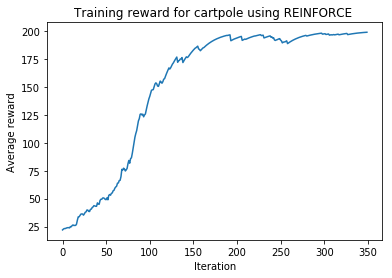

In [18]:
n_iter = 1000 
min_timesteps_per_batch = 2000  # sets the batch size for updating network
avg_reward = 0
avg_rewards_reinforce = []
step_list_reinforce = []
total_steps = 0
episodes = 0
logging_interval = 10

if envName =='cartpole':
    term_condition = 199 # Pendulum
elif envName == 'inverted pendulum':
    term_condition = 500
elif envName == 'cheetah':
    term_condition = 1500
    
for itr in range(n_iter): # loop for number of optimization steps
    paths = []
    steps = 0
    animate_this_episode = (itr % logging_interval == 0) and VISUALIZE
    while True: # loop to get enough timesteps in this batch --> if episode ends this loop will restart till steps reaches limit
        ob = env.reset()
        ob = np.reshape(ob, [1, ob.size])
        obs, acs, rews, log_odds = [], [], [], [] 
        
        while True: # loop for episode inside batch
            if animate_this_episode:
                env.render()
                time.sleep(0.05)
            
            # get parametrized policy distribution from net using current state ob
            logit  = net(Variable(torch.from_numpy(ob).float().cuda()))
            # sample action and get log-probability (log_odds) from distribution
            action, log_odd = sample_action(logit, discrete)
            #print(action)
            action = action.cpu().detach().numpy()[0]
            #print(action)
            # step environment, record reward, next state
            obs.append(ob)
            ob,rewards,done,_= env.step(action)
            ob = np.reshape(ob, [1, ob.size])
            # append to obs, acs, rewards, log_odds
            acs.append(action)
            rews.append(rewards)
            #print(log_odd)
            log_odds.append(log_odd)
            # if done, restart episode till min_timesteps_per_batch is reached
                     
            steps += 1
            if done:
                episodes = episodes + 1
                break
                
        path = {"observation" : obs, 
                "reward" : np.array(rews), 
                "action" : (acs),
                "log_odds" : log_odds}
        
        paths.append(path)
        
        if steps > min_timesteps_per_batch:
            break 
        
    update_policy(paths, net)  # use all complete episodes (a batch of timesteps) recorded in this itr to update net
    
    if itr == 0:
        avg_reward = path['reward'].sum()
    else:
        avg_reward = avg_reward * 0.95 + 0.05 * path['reward'].sum()
    
    if avg_reward >= term_condition:
        print(avg_reward)
        break
    
    total_steps += steps
    avg_rewards_reinforce.append(avg_reward)
    step_list_reinforce.append(total_steps)
    if itr % logging_interval == 0:
        print('Average reward: {}'.format(avg_reward))
   
      
env.close()

plt.plot(avg_rewards_reinforce)
plt.title('Training reward for {} using REINFORCE '.format(envName))
plt.xlabel('Iteration')
plt.ylabel('Average reward')

# BONUS (15% extra)

Compare average returns for CartPole (discrete action space) when using REINFORCE and DQN. Since in REINFORCE we update the network after a set number of steps instead of after every episode, plot the average rewards as a function of steps rather than episodes for both DQN and REINFORCE. You will need to make minor edits to your DQN code from the previous assignment to record average returns as a function of time_steps.

Similarly, compare REINFORCE with DDPG on InvertedPendulum and HalfCheetah using steps for the x-axis.

You may use the example code provided below as a reference for the graphs.


In [19]:
 # import your DQN and format your average returns as defined above
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
# Create the CartPole game environment
env = gym.make('CartPole-v0')
term_condition = 199
class QNetwork(nn.Module):
# Define your network here   
    def __init__(self,learning_rate = 0.01, state_size=4, action_size=2, hidden_size=20, alpha_decay=0.01):
        super(QNetwork, self).__init__()
        self.learning_rate = learning_rate
        self.alpha_decay = alpha_decay
        self.fc1 = nn.Linear(state_size, hidden_size,bias=True)
        #torch.nn.init.xavier_uniform(self.fc1.weight)
        self.fc2 = nn.Linear(hidden_size, hidden_size,bias=True)
        #torch.nn.init.xavier_uniform(self.fc2.weight)
        self.fc3 = nn.Linear(hidden_size, action_size,bias=True)
        #torch.nn.init.xavier_uniform(self.fc3.weight)
        #initialize loss criterion
        self.criterion = nn.MSELoss()
        
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        #x = self.fc3(x)
        return x
        #initilize an optimizer
    def initialize(self):
        self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        self.schedule = optim.lr_scheduler.ExponentialLR(self.optimizer,self.alpha_decay)
    def copy(self,net):
        self.load_state_dict(net.state_dict())
        

DQN = QNetwork()
DQN.initialize()
DQNc = QNetwork()
DQNc.copy(DQN)


print (DQN)
print (DQNc)

class Replay():
    def __init__(self,max_size):
        self.max_size = max_size
        self.replay_buffer = []
        
    def initialize(self,init_length,env):
        observation = env.reset()
        for steps in range(init_length):
            #time.sleep(0.05)
            #env.render()
            experience = []
            observation = np.reshape(observation, [1, observation.size])
            experience.append(observation)
            action = env.action_space.sample()
            experience.append(action)
            
            observation,reward,done,_= env.step(action)
                #env.action_space.sample()
            experience.append(reward)
            observation = np.reshape(observation, [1, observation.size])
            experience.append(observation)
            experience.append(done)
            self.replay_buffer.append(experience)
            
            if done == True:
                observation = env.reset()
                
    def add_memory(self,memory):
        if len(self.replay_buffer) > self.max_size:
            self.replay_buffer.pop(0)
            self.replay_buffer.append(memory)
        else:
            self.replay_buffer.append(memory)
            
    def generate_minibatch(self,DQN,targetDQN,batch_size,discount_factor = 0.99):
        states = []
        targets = []
        dataset_end = len(self.replay_buffer)
        #start = np.random.randint(dataset_end-batch_size)
        for step in range(batch_size):
            step = np.random.randint(dataset_end)
            state = (self.replay_buffer[step][0])
            
            states.append(np.reshape(state,state.size))
            state = Variable(torch.from_numpy(state).float())
            next_state = self.replay_buffer[step][3]
            next_state = np.reshape(next_state, [1, next_state.size])
            next_state = Variable(torch.from_numpy(next_state).float())
            y = [0.,0.]
            action = self.replay_buffer[step][1]
            if action == 0:
                opposite_action =1
            elif action ==1:
                opposite_action = 0
            else:
                print ("error something went wrong")
            #pposite_action = (action-1)*(-1)
            
            DQNs = DQN(state).data[0][opposite_action]
            
            y[opposite_action] = DQNs
            if self.replay_buffer[step][4]:
                y[action] = (self.replay_buffer[step][2])
            else:
                future = (discount_factor*torch.max(targetDQN(next_state)).data[0])
                y[action] = (self.replay_buffer[step][2]+future)
            targets.append(y)
        states = np.asarray(states)
        targets = np.asarray(targets)
        #print np.shape(states)
        #print np.shape(targets)
        return states,targets
# Replay should also have an initialize method which creates a minimum buffer for 
# the initial episodes to generate minibatches.  


#constants
state_size = 4
action_size = 2
# Initialize DQN params
learning_rate = 0.01
alpha_decay = 0.99
hidden_size = 50
avg_reward = 0
# Play around with your learning rate, alpha decay and hidden layer units 

# Two layers with a small number of units should be enough
DQN = QNetwork(learning_rate, state_size, action_size, hidden_size, alpha_decay)
DQN.initialize()
targetDQN = QNetwork(learning_rate, state_size, action_size, hidden_size, alpha_decay)
#targetDQN.initialize()

# set targetDQN weights to DQN weights
targetDQN.copy(DQN)
# for ex. targetDQN.model.weights = DQN.model.weights (syntax given here is for representation purpose only)

## Initialize Replay Buffer
###################################
## Populate the initial experience buffer
###################################

replay = Replay(max_size=10000)
replay.initialize(init_length=1000, env=env)

# Runtime parameters
num_episodes = 2000           # max number of episodes to learn from
gamma = 0.99                   # future reward discount
max_steps = 500                # cut off simulation after this many steps
batch_size = 64
# Exploration parameters
min_epsilon = 0.01          # minimum exploration probability
decay_rate = 5./num_episodes    # exponential decay rate for exploration prob
returns = np.zeros(num_episodes)
totalSteps = 0
running_rewards_DQN = []
avg_rewards_DQN = []
step_list_DQN = []
total_steps = 0
logging_interval = 20
VISUALIZE = True
done_recording = False
logdir='./DQN/'
if VISUALIZE:
    if not os.path.exists(logdir):
        os.mkdir(logdir)
    env = gym.wrappers.Monitor(env, logdir, force=True, video_callable=lambda episode_id: episode_id%logging_interval==0)
#env._max_episodes_steps = MAX_PATH_LENGTH


for ep in range(1, num_episodes):
    animate_this_episode = (ep % logging_interval == 0) and VISUALIZE
    epsilon = min_epsilon + (1.0 - min_epsilon)*np.exp(-decay_rate*ep)
    #print epsilon
    if ep%50 == 0:
        print (ep)
    observation = env.reset()
    done = False
    total_reward = 0
    itr = 0
    steps = 0
    while not done and itr < max_steps:
        if animate_this_episode:
                env.render()
                time.sleep(0.05)
        itr+=1
        experience = []
        observation = np.reshape(observation, [1, observation.size])
        experience.append(observation)
        observation = Variable(torch.from_numpy(observation).float())
        if np.random.binomial(1,epsilon):
            action = env.action_space.sample()
            #print action
        else:
            action = np.argmax(DQN(observation).data.numpy())
            
            #print DQN(observation)
            #print "not taking random"
        experience.append(action)
            
        observation,reward,done,_= env.step(action)
                #env.action_space.sample()
        experience.append(reward)
        observation = np.reshape(observation, [1, observation.size])
        experience.append(observation)
        experience.append(done)
        total_reward+=reward
        
        replay.add_memory(experience)
        total_steps +=1
    # --> start episode 
    # explore/exploit and get action using DQN
    # perform action and record new_state, action, reward
    # populate Replay experience buffer
    # <-- end episode
    
    returns[ep] = total_reward
    if itr == 0:
        avg_reward = total_reward
    else:
        avg_reward = avg_reward * 0.95 + 0.05 * total_reward
    
    if avg_reward >= term_condition:
        print(avg_reward)
        break
    
    total_steps += steps
    avg_rewards_DQN.append(avg_reward)
    step_list_DQN.append(total_steps)
    if itr % logging_interval == 0:
        print('Average reward: {}'.format(avg_reward))
        
    running_rewards_DQN.append(total_reward)
    
    # Replay
    for epoch in range(1):
        DQN.schedule.step()
        states,targets = replay.generate_minibatch(DQN, targetDQN, batch_size)
        targetDQN.copy(DQN)
    
        target =  Variable(torch.from_numpy(targets).float())
        output = DQN(Variable(torch.from_numpy(states).float()))
        loss = DQN.criterion(output,target)
        DQN.optimizer.zero_grad()
        loss.backward()
        DQN.optimizer.step()
        
        

[2018-05-22 16:27:48,113] Making new env: CartPole-v0
[2018-05-22 16:27:48,167] Clearing 52 monitor files from previous run (because force=True was provided)
[2018-05-22 16:27:48,239] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000000.mp4


QNetwork(
  (fc1): Linear(in_features=4, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=2, bias=True)
  (criterion): MSELoss()
)
QNetwork(
  (fc1): Linear(in_features=4, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=2, bias=True)
  (criterion): MSELoss()
)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 2.65775
Average reward: 7.694594411640623


[2018-05-22 16:27:51,779] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000020.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 19.75832340206416


[2018-05-22 16:28:00,084] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000040.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


50


[2018-05-22 16:28:04,480] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000060.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 18.848353886106587


[2018-05-22 16:28:08,373] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000080.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 20.59217410235478
100


[2018-05-22 16:28:12,779] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000100.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
[2018-05-22 16:28:16,659] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000120.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
[2018-05-22 16:28:20,280] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000140.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.it

150
Average reward: 33.602179736470305
Average reward: 32.314416658978416


[2018-05-22 16:28:23,185] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000160.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
[2018-05-22 16:28:27,152] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000180.mp4


Average reward: 37.25798284287882


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 37.91074564352168
200


[2018-05-22 16:28:30,396] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000200.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 45.61982974835548
Average reward: 47.09817653049627
Average reward: 45.645296647692525


[2018-05-22 16:28:33,887] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000220.mp4


Average reward: 43.56626372676686


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
[2018-05-22 16:28:40,312] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000240.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 53.78411404802477
250
Average reward: 64.25539620912673
Average reward: 61.62534143222541


[2018-05-22 16:28:51,578] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000260.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 73.63899575945074
Average reward: 83.4114836753063


[2018-05-22 16:28:56,078] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000280.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 77.93285204072818
Average reward: 91.20057639130887
300
Average reward: 100.08946918349844


[2018-05-22 16:29:10,582] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000300.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
[2018-05-22 16:29:18,992] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000320.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 98.03007421954052


[2018-05-22 16:29:28,191] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000340.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


350


[2018-05-22 16:29:39,815] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000360.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 98.2723440693358
Average reward: 104.58079052257555


[2018-05-22 16:29:50,999] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000380.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 92.01402042940369
Average reward: 97.6978181320827
400


[2018-05-22 16:29:56,681] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000400.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 112.90741445173516
Average reward: 121.0517884922786
Average reward: 124.99919906766466


[2018-05-22 16:30:11,293] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000420.mp4


Average reward: 128.36697263560703
Average reward: 131.94862400382667


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 135.35119280363534
Average reward: 138.58363316345356
Average reward: 141.65445150528086
Average reward: 144.5717289300168
Average reward: 147.34314248351595
Average reward: 149.97598535934014
Average reward: 152.47718609137314
Average reward: 154.85332678680447
Average reward: 157.11066044746426
Average reward: 159.25512742509105
Average reward: 161.2923710538365
Average reward: 163.22775250114466
Average reward: 166.00554663228306
Average reward: 156.77263054385367
Average reward: 158.08979906582792


[2018-05-22 16:30:26,866] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000440.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 153.1985436569097
Average reward: 155.5386164740642
Average reward: 156.6560780352543
450
Average reward: 159.69461042681698
Average reward: 161.70987990547613
Average reward: 164.82566661469218
Average reward: 164.58438328395758
Average reward: 163.04990591377168
Average reward: 164.8974106180831
Average reward: 166.65254008717892
Average reward: 168.31991308281997


[2018-05-22 16:30:40,869] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000460.mp4


Average reward: 170.696221557245


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 172.1283399554136
Average reward: 171.1588216985186
Average reward: 172.60088061359266
Average reward: 173.97083658291302
Average reward: 175.27229475376737
Average reward: 176.50868001607898
Average reward: 177.68324601527502
Average reward: 178.10162952878568
Average reward: 178.52672064972907
Average reward: 179.62286538638045


[2018-05-22 16:30:55,016] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000480.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 172.00576282350528
Average reward: 173.40547468233
Average reward: 174.7352009482135
Average reward: 176.34834291297454
Average reward: 177.5309257673258
Average reward: 178.29666050501154
500


[2018-05-22 16:31:10,183] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000500.mp4


Average reward: 178.12309504400267


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 178.5455963385489
Average reward: 179.61831652162144
Average reward: 173.2735515377719
Average reward: 175.35688026283913
Average reward: 176.58903624969716
Average reward: 178.49160521535165


[2018-05-22 16:31:22,978] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000520.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 170.40010286941467
Average reward: 172.9060928396467
Average reward: 175.35774878778116
Average reward: 170.5898613483921
Average reward: 172.41234986692385
Average reward: 175.72587404379613
Average reward: 177.04760132452597


[2018-05-22 16:31:35,785] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000540.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


550
Average reward: 168.71925971815045
Average reward: 170.05913189563074
Average reward: 172.43053759570543


[2018-05-22 16:31:49,059] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000560.mp4


Average reward: 173.80901071592015


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 173.9401321711179
Average reward: 173.9159692844339
Average reward: 174.52970416524153
Average reward: 176.53805800913045
Average reward: 178.20809735324022
Average reward: 179.2976924855782
Average reward: 180.3328078612993
Average reward: 181.31616746823434
Average reward: 181.80784114008148
Average reward: 181.7765766289235


[2018-05-22 16:32:01,884] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000580.mp4


Average reward: 180.19094238722326


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 181.1813952678621
Average reward: 182.1612092292455
Average reward: 178.55230687853918
Average reward: 179.62469153461223
Average reward: 181.5637841099875
Average reward: 178.18097443123548
600


[2018-05-22 16:32:14,793] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000600.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 177.35038054580846
Average reward: 178.27621844259212
Average reward: 179.3624075204625
Average reward: 178.8851519404637
Average reward: 179.37458053770726
Average reward: 180.4058515108219
Average reward: 181.84128098851673


[2018-05-22 16:32:30,302] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000620.mp4


Average reward: 181.42675609213632
Average reward: 182.3554182875295


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 183.237647373153
Average reward: 184.07576500449534
Average reward: 184.87197675427058
Average reward: 185.87195902072918
Average reward: 186.5783610696927
Average reward: 187.24944301620806
Average reward: 188.11262232212775
Average reward: 188.70699120602134
Average reward: 188.90555956343428
Average reward: 189.46028158526255
Average reward: 185.02540413069946
Average reward: 185.7741339241645
Average reward: 186.48542722795625
Average reward: 187.16115586655843


[2018-05-22 16:32:46,963] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000640.mp4


Average reward: 187.8030980732305
Average reward: 188.41294316956896


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 186.97567215000916
Average reward: 187.62688854250868
Average reward: 188.24554411538324
Average reward: 187.7916483859267
650
Average reward: 188.40206596663035
Average reward: 189.24786453488386
Average reward: 184.64438785559602
Average reward: 185.41216846281623
Average reward: 184.6969820376916
Average reward: 185.46213293580703


[2018-05-22 16:33:02,305] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000660.mp4


Average reward: 186.18902628901668
Average reward: 186.87957497456583


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 187.53559622583754
Average reward: 188.15881641454564
Average reward: 188.75087559381836
Average reward: 189.31333181412745
Average reward: 189.2676428641375
Average reward: 189.4115476848841
Average reward: 189.9409703006399
Average reward: 190.4439217856079
Average reward: 189.8556394115111
Average reward: 190.36285744093556
Average reward: 189.7067298984221
Average reward: 190.221393403501


[2018-05-22 16:33:19,232] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000680.mp4


Average reward: 190.71032373332594
Average reward: 191.17480754665962


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 191.61606716932664
Average reward: 192.0352638108603
Average reward: 190.05285930983632
Average reward: 190.5502163443445
Average reward: 189.85657025077091
Average reward: 190.32305465132072
Average reward: 190.80690191875468
Average reward: 191.26655682281694
Average reward: 192.07056753259226
Average reward: 192.3686871981645
Average reward: 192.21024019634345
700


[2018-05-22 16:33:34,682] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000700.mp4


Average reward: 192.59972818652628
Average reward: 192.96974177719994


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 193.32125468833993
Average reward: 193.65519195392292
Average reward: 193.97243235622676
Average reward: 194.27381073841542
Average reward: 194.56012020149464
Average reward: 194.23550848184888
Average reward: 194.52373305775643
Average reward: 194.7975464048686
Average reward: 195.05766908462516
Average reward: 194.51310307985892
Average reward: 194.78744792586596
Average reward: 195.04807552957266
Average reward: 195.295671753094
Average reward: 195.5308881654393


[2018-05-22 16:33:49,778] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000720.mp4


Average reward: 195.63412656930896


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 195.85242024084351
Average reward: 196.05979922880132
Average reward: 195.1114688039932
Average reward: 195.35589536379354
Average reward: 195.58810059560386
Average reward: 195.80869556582365
Average reward: 193.50305009271062
Average reward: 193.82789758807507
Average reward: 194.13650270867132
Average reward: 194.42967757323774
Average reward: 193.70819369457584
Average reward: 194.02278400984704
Average reward: 194.27306256888696


[2018-05-22 16:34:05,683] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000740.mp4


Average reward: 194.5594094404426


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 192.90486701999941
Average reward: 193.25962366899944
Average reward: 192.44209484320834
Average reward: 192.81999010104792
Average reward: 193.17899059599551
750
Average reward: 192.63658706224163
Average reward: 191.97701982367306
Average reward: 192.3781688324894
Average reward: 192.7592603908649
Average reward: 193.12129737132165
Average reward: 193.46523250275555
Average reward: 193.79197087761776
Average reward: 194.10237233373687


[2018-05-22 16:34:20,078] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000760.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 192.2740214796376
Average reward: 192.6603204056557
Average reward: 193.02730438537293
Average reward: 192.8876208425386
Average reward: 193.24323980041166
Average reward: 193.58107781039106
Average reward: 192.92442272387794
Average reward: 193.27820158768404
Average reward: 193.2607730862406
Average reward: 193.59773443192856
Average reward: 193.91784771033213
Average reward: 194.2219553248155


[2018-05-22 16:34:34,479] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000780.mp4


Average reward: 194.5108575585747


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 193.24104894661366
Average reward: 193.57899649928297
Average reward: 193.90004667431882
Average reward: 194.20504434060285
Average reward: 194.4947921235727
Average reward: 193.98654989152433
Average reward: 194.2872223969481
Average reward: 194.57286127710069
Average reward: 194.84421821324565
Average reward: 195.10200730258336
Average reward: 195.34690693745418
Average reward: 195.18308351105236
Average reward: 195.41523286872473
Average reward: 195.64447122528847
Average reward: 195.86224766402404
800


[2018-05-22 16:34:52,681] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000800.mp4


Average reward: 196.06913528082282
Average reward: 196.26567851678166


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 196.45239459094256
Average reward: 195.70578611832562
Average reward: 195.92049681240934
Average reward: 196.12447197178886
Average reward: 195.36233595453945
Average reward: 195.59421915681247
Average reward: 195.81450819897185
Average reward: 196.02378278902324
Average reward: 196.22259364957208
Average reward: 194.40589076873877
Average reward: 194.68559623030183
Average reward: 194.95131641878672
Average reward: 195.20375059784737
Average reward: 195.44356306795498


[2018-05-22 16:35:06,513] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000820.mp4


Average reward: 193.29567488538788


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 193.6643465840625
Average reward: 193.98112925485938
Average reward: 194.2820727921164
Average reward: 194.56796915251056
Average reward: 194.83957069488503
Average reward: 195.09759216014078
Average reward: 195.34271255213372
Average reward: 195.575576924527
Average reward: 193.9169581743856
Average reward: 194.2211102656663
Average reward: 194.51005475238298
Average reward: 194.0478244140256
Average reward: 194.3454331933243
Average reward: 194.62816153365807
Average reward: 194.89675345697515


[2018-05-22 16:35:21,281] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000840.mp4


Average reward: 195.15191578412637


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 194.0454987954153
Average reward: 194.34322385564454
Average reward: 194.6260626628623
Average reward: 193.9150215532332
Average reward: 194.21927047557153
Average reward: 194.50830695179295
850
Average reward: 194.37874702399313
Average reward: 194.65980967279347
Average reward: 194.92681918915378
Average reward: 195.18047822969606
Average reward: 195.42145431821126
Average reward: 195.65038160230068
Average reward: 195.86786252218565
Average reward: 196.07446939607635
Average reward: 196.27074592627253


[2018-05-22 16:35:35,828] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000860.mp4


Average reward: 195.58934819846095


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 195.829386749111
Average reward: 195.66602154107267
Average reward: 195.88272046401903
Average reward: 196.04665521877715
Average reward: 196.24432245783828
Average reward: 196.43210633494635
Average reward: 196.61050101819902
Average reward: 196.77997596728906
Average reward: 196.9409771689246
Average reward: 197.09392831047836
Average reward: 197.23923189495443
Average reward: 197.3772703002067
Average reward: 197.50840678519637
Average reward: 197.63298644593655
Average reward: 197.75133712363973


[2018-05-22 16:35:51,398] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000880.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 196.75867766638058
Average reward: 196.92074378306154
Average reward: 197.07470659390845
Average reward: 197.220971264213
Average reward: 197.35992270100235
Average reward: 197.4919265659522
Average reward: 197.61733023765458
Average reward: 197.73646372577184
Average reward: 197.84964053948323
Average reward: 197.95715851250907
Average reward: 198.0593005868836
Average reward: 198.15633555753942
Average reward: 198.24851877966245
Average reward: 196.89928819864537
Average reward: 197.05432378871308
900


[2018-05-22 16:36:05,904] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000900.mp4


Average reward: 194.32257585834785


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 193.35612471215893
Average reward: 192.4839025527234
Average reward: 192.85970742508724
Average reward: 193.21672205383285
Average reward: 193.5558859511412
Average reward: 193.87809165358414
Average reward: 194.18418707090493
Average reward: 194.47497771735968
Average reward: 194.7512288314917
Average reward: 195.0136673899171
Average reward: 195.45233481940014
Average reward: 195.6797180784301
Average reward: 195.8957321745086
Average reward: 196.10094556578315
Average reward: 196.29589828749397
Average reward: 196.48110337311925


[2018-05-22 16:36:20,588] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000920.mp4


Average reward: 196.65704820446328
Average reward: 196.8241957942401


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 196.94383670430167
Average reward: 197.0966448690866
Average reward: 197.24181262563226
Average reward: 197.37972199435063
Average reward: 197.5107358946331
Average reward: 197.63519909990143
Average reward: 196.77326718766102
Average reward: 196.93460382827797
Average reward: 197.08787363686406
Average reward: 197.23347995502084
Average reward: 197.3718059572698
Average reward: 197.5032156594063
Average reward: 197.62805487643598
Average reward: 197.74665213261417
Average reward: 197.85931952598347
Average reward: 197.96635354968427


[2018-05-22 16:36:37,784] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000940.mp4


Average reward: 198.06803587220006
Average reward: 198.16463407859004


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 198.25640237466052
Average reward: 197.95883298597454
Average reward: 195.45695443134989
950
Average reward: 195.23490137429326
Average reward: 195.47315630557858
Average reward: 195.69949849029965
Average reward: 195.91452356578466
Average reward: 196.11879738749542
Average reward: 196.31285751812064
Average reward: 196.4972146422146
Average reward: 196.67235391010385
Average reward: 196.83873621459864
Average reward: 196.9967994038687
Average reward: 197.14695943367525


[2018-05-22 16:36:56,823] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000960.mp4


Average reward: 197.28961146199148


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 197.4251308888919
Average reward: 197.5538743444473
Average reward: 196.10274661526694
Average reward: 196.19772882027837
Average reward: 196.38784237926444
Average reward: 196.5684502603012
Average reward: 196.74002774728615
Average reward: 196.90302635992182
Average reward: 197.0578750419257
Average reward: 197.20498128982942
Average reward: 197.34473222533794
Average reward: 197.47749561407102
Average reward: 197.60362083336744
Average reward: 197.72343979169906


[2018-05-22 16:37:11,793] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video000980.mp4


Average reward: 197.66040441200838


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 197.77738419140795
Average reward: 197.88851498183755
Average reward: 197.99408923274567
Average reward: 198.09438477110837
Average reward: 198.18966553255294
Average reward: 198.28018225592527
Average reward: 197.07036448597256
Average reward: 197.21684626167394
Average reward: 197.3932037511607
Average reward: 197.52354356360266
Average reward: 197.28999806615138
Average reward: 197.4592232547016
Average reward: 197.58626209196652
Average reward: 197.70694898736818
1000


[2018-05-22 16:37:26,776] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video001000.mp4


Average reward: 197.82160153799975


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 197.36899538804477
Average reward: 197.50054561864252
Average reward: 197.6255183377104
Average reward: 197.0495302997836
Average reward: 196.4822010955547
Average reward: 196.65809104077695
Average reward: 196.27142716430117
Average reward: 196.45785580608612
Average reward: 195.76130412174305
Average reward: 195.97323891565588
Average reward: 196.17457696987307
Average reward: 195.95067792954487


[2018-05-22 16:37:45,455] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video001020.mp4


Average reward: 196.1531440330676


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 196.3454868314142
Average reward: 196.5593018653513
Average reward: 195.5647699334795
Average reward: 194.23970486496523
Average reward: 194.52771962171695
Average reward: 194.8013336406311
Average reward: 195.06126695859953
Average reward: 194.87779343013608
Average reward: 195.13390375862926
Average reward: 194.8958481421629
Average reward: 195.15105573505474
Average reward: 195.393502948302


[2018-05-22 16:38:01,574] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video001040.mp4


Average reward: 194.41763641084253
Average reward: 194.6967545903004


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 194.9288210177461
Average reward: 195.18237996685878
Average reward: 195.42326096851582
Average reward: 195.65209792009003
Average reward: 195.86949302408553
Average reward: 196.07601837288124
1050
Average reward: 194.8911065815253
Average reward: 195.14655125244903
Average reward: 195.38922368982657
Average reward: 195.61976250533522
Average reward: 194.57433566106502
Average reward: 194.84561887801175
Average reward: 195.10333793411115
Average reward: 195.3481710374056
Average reward: 195.5807624855353


[2018-05-22 16:38:16,733] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video001060.mp4


Average reward: 195.80172436125852
Average reward: 196.0116381431956


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 196.2110562360358
Average reward: 196.400503424234
Average reward: 196.58047825302228
Average reward: 196.75145434037117
Average reward: 196.9138816233526
Average reward: 197.06818754218497
Average reward: 195.80008729398082
Average reward: 196.01008292928177
Average reward: 195.20957878281766
Average reward: 195.44909984367678
Average reward: 195.67664485149294
Average reward: 195.8928126089183
Average reward: 196.09817197847238
Average reward: 196.29326337954876
Average reward: 196.4786002105713


[2018-05-22 16:38:30,922] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video001080.mp4


Average reward: 196.22321485553854


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 196.4120541127616
Average reward: 196.59145140712351
Average reward: 195.73628489492896
Average reward: 195.9494706501825
Average reward: 187.18867739870018
Average reward: 187.82924352876518
Average reward: 188.4377813523269
Average reward: 189.01589228471056
Average reward: 189.565097670475
Average reward: 190.08684278695125
Average reward: 190.5825006476037
Average reward: 190.9307068344623
Average reward: 191.3841714927392
Average reward: 191.81496291810222
1100


[2018-05-22 16:38:46,304] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video001100.mp4


Average reward: 192.22421477219712


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 191.49261114031248
Average reward: 191.91798058329684
Average reward: 192.32208155413198
Average reward: 192.70597747642537
Average reward: 193.03714467247386
Average reward: 192.67102306690765
Average reward: 193.2460684019899
Average reward: 193.5837649818904
Average reward: 193.11684789615606
Average reward: 193.46100550134824


[2018-05-22 16:39:01,985] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video001120.mp4


Average reward: 191.79537959171842
Average reward: 192.2056106121325


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 192.59533008152584
Average reward: 192.96556357744953
Average reward: 193.31728539857704
Average reward: 193.65142112864817
Average reward: 193.3266371901747
Average reward: 193.66030533066595
Average reward: 193.97729006413263
Average reward: 194.278425560926
Average reward: 194.56450428287968
Average reward: 193.7644651152989
Average reward: 193.08992976655722
Average reward: 193.43543327822934
Average reward: 193.76366161431787


[2018-05-22 16:39:17,359] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video001140.mp4


Average reward: 192.51920460692187
Average reward: 192.89324437657578


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 193.248582157747
Average reward: 193.58615304985963
Average reward: 193.90684539736665
Average reward: 193.26592797112338
Average reward: 193.6026315725672
Average reward: 193.92249999393883
Average reward: 194.22637499424187
1150
Average reward: 194.51505624452977
Average reward: 194.78930343230329
Average reward: 195.04983826068812
Average reward: 195.2973463476537
Average reward: 194.28335507875744
Average reward: 194.56918732481955
Average reward: 194.84072795857855
Average reward: 193.77625698261713


[2018-05-22 16:39:32,483] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video001160.mp4


Average reward: 193.33807192681195


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 193.67116833047135
Average reward: 193.67072941825037
Average reward: 193.98719294733786
Average reward: 194.28783329997097
Average reward: 194.57344163497243
Average reward: 194.84476955322378
Average reward: 195.10253107556258
Average reward: 195.15253429569523
Average reward: 195.39490758091046
Average reward: 195.62516220186492
Average reward: 195.84390409177166
Average reward: 196.05170888718308
Average reward: 196.24912344282393
Average reward: 196.43666727068273
Average reward: 196.11909221179116
Average reward: 196.3131376012016


[2018-05-22 16:39:49,509] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video001180.mp4


Average reward: 196.4974807211415


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 196.67260668508442
Average reward: 196.71202753328868
Average reward: 196.87642615662423
Average reward: 197.032604848793
Average reward: 197.22692587603566
Average reward: 196.30980060312217
Average reward: 196.49431057296604
Average reward: 196.66959504431773
Average reward: 195.64834405112188
Average reward: 195.86592684856578
Average reward: 196.07263050613747
Average reward: 196.2689989808306
Average reward: 196.45554903178905
1200


[2018-05-22 16:40:04,176] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video001200.mp4


Average reward: 196.63277158019957
Average reward: 196.80113300118958


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 196.9610763511301
Average reward: 194.15500283655015
Average reward: 194.6773900599865
Average reward: 194.94352055698715
Average reward: 195.19634452913778
Average reward: 195.43652730268087
Average reward: 194.88396589066946
Average reward: 194.05277921632916
Average reward: 194.35014025551268
Average reward: 194.63263324273703
Average reward: 194.90100158060017
Average reward: 195.15595150157014
Average reward: 195.39815392649163


[2018-05-22 16:40:19,950] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video001220.mp4


Average reward: 195.62824623016704
Average reward: 195.8468339186587


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 195.68176761158946
Average reward: 195.29529526945947
Average reward: 195.5305305059865
Average reward: 195.4913037816528
Average reward: 195.69340166294162
Average reward: 195.90873157979453
Average reward: 196.1132950008048
Average reward: 196.30763025076456
Average reward: 196.49224873822632
Average reward: 196.66763630131499
Average reward: 196.83425448624922
Average reward: 196.99254176193676
Average reward: 197.14291467383993


[2018-05-22 16:40:36,783] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video001240.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 195.3489486450593
Average reward: 195.6370548445577
Average reward: 195.8552021023298
Average reward: 196.0624419972133
Average reward: 196.25931989735264
Average reward: 196.446353902485
1250
Average reward: 196.62403620736072
Average reward: 196.79283439699267
Average reward: 196.95319267714302
Average reward: 197.10553304328587
Average reward: 197.25025639112158
Average reward: 196.59031357333782
Average reward: 196.76079789467093


[2018-05-22 16:40:52,209] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video001260.mp4


Average reward: 196.22162009994048
Average reward: 196.41053909494346


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 196.59001214019628
Average reward: 196.76051153318645
Average reward: 196.9224859565271
Average reward: 196.60504357576568
Average reward: 196.3660518271285
Average reward: 196.54774923577207
Average reward: 196.72036177398346
Average reward: 196.88434368528428
Average reward: 197.04012650102007
Average reward: 197.18812017596906
Average reward: 197.3287141671706
Average reward: 197.46227845881205
Average reward: 197.58916453587145
Average reward: 197.70970630907786
Average reward: 197.82422099362395
Average reward: 197.93300994394275


[2018-05-22 16:41:09,156] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video001280.mp4


Average reward: 197.65954147440831


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 197.7765644006879
Average reward: 197.8877361806535
Average reward: 197.9933493716208
Average reward: 198.09368190303977
Average reward: 198.18899780788777
Average reward: 198.27954791749337
Average reward: 198.3655705216187
Average reward: 198.44729199553777
Average reward: 198.52492739576087
Average reward: 198.5986810259728
Average reward: 198.66874697467415
Average reward: 198.73530962594043
Average reward: 198.0036169374112
Average reward: 196.9157642860136
Average reward: 197.06997607171292
Average reward: 197.21647726812725
1300


[2018-05-22 16:41:24,301] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video001300.mp4


Average reward: 197.2028707344848


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 197.34272719776055
Average reward: 197.47559083787252
Average reward: 197.60181129597888
Average reward: 197.7881346946209
Average reward: 197.89872795988984
Average reward: 198.00379156189533
Average reward: 196.7259218846105
Average reward: 196.88962579037997
Average reward: 196.1478872758179
Average reward: 196.340492912027
Average reward: 196.52346826642565
Average reward: 196.69729485310435
Average reward: 196.86243011044914
Average reward: 197.01930860492666
Average reward: 197.16834317468033


[2018-05-22 16:41:41,709] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video001320.mp4


Average reward: 197.3099260159463


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 197.47720822939152
Average reward: 197.60334781792193
Average reward: 197.72318042702582
Average reward: 197.83702140567453
Average reward: 197.9451703353908
Average reward: 198.04791181862126
Average reward: 197.04857839549038
Average reward: 197.19614947571586
Average reward: 197.33634200193006
Average reward: 197.46952490183355
Average reward: 197.59604865674186
Average reward: 197.71624622390476
Average reward: 197.8304339127095
Average reward: 197.37696660622032


[2018-05-22 16:41:56,688] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video001340.mp4


Average reward: 196.96771236211382
Average reward: 197.1193267440081


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 197.2633604068077
Average reward: 197.4001923864673
Average reward: 197.5301827671439
Average reward: 197.65367362878672
Average reward: 197.26494044998
Average reward: 197.401693427481
Average reward: 197.53160875610695
1350
Average reward: 197.6550283183016
Average reward: 197.7722769023865
Average reward: 197.88366305726717
Average reward: 197.9894799044038
Average reward: 198.0900059091836
Average reward: 198.03873033303816
Average reward: 198.13679381638624
Average reward: 198.22995412556693


[2018-05-22 16:42:12,649] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video001360.mp4


Average reward: 198.11753359832412
Average reward: 198.2116569184079


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 198.3010740724875
Average reward: 197.75421935041996
Average reward: 197.86650838289896
Average reward: 197.973182963754
Average reward: 198.0745238155663
Average reward: 198.17079762478798
Average reward: 197.77914485637112
Average reward: 197.89018761355254
Average reward: 198.00089432123116
Average reward: 197.9583071249111
Average reward: 198.06039176866554
Average reward: 196.87200357122063
Average reward: 197.02840339265958


[2018-05-22 16:42:27,508] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video001380.mp4


Average reward: 197.17698322302658
Average reward: 197.31813406187524


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 196.4396159908424
Average reward: 196.61763519130028
Average reward: 196.78675343173526
Average reward: 196.9474157601485
Average reward: 197.10004497214106
Average reward: 197.245042723534
Average reward: 197.38279058735728
Average reward: 197.5136510579894
Average reward: 197.6379685050899
Average reward: 197.7560700798354
Average reward: 197.86826657584362
Average reward: 197.97485324705144
Average reward: 198.07611058469885
Average reward: 198.1723050554639
Average reward: 198.2636898026907
Average reward: 198.35050531255615
Average reward: 198.43298004692832
1400


[2018-05-22 16:42:43,004] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video001400.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 196.69947626773512
Average reward: 195.7862773316309
Average reward: 195.99696346504936
Average reward: 196.19711529179688
Average reward: 196.38725952720702
Average reward: 196.56789655084665
Average reward: 196.7395017233043
Average reward: 196.9025266371391
Average reward: 197.05740030528213
Average reward: 196.20453029001803
Average reward: 196.39430377551713
Average reward: 196.57458858674127
Average reward: 196.7458591574042
Average reward: 196.90856619953396
Average reward: 197.06313788955725
Average reward: 197.20998099507938
Average reward: 197.3494819453254


[2018-05-22 16:43:00,094] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video001420.mp4


Average reward: 197.48200784805914
Average reward: 197.60790745565617


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 197.72751208287335
Average reward: 197.84113647872968
Average reward: 197.9490796547932
Average reward: 198.05162567205352
Average reward: 198.14904438845085
Average reward: 198.2415921690283
Average reward: 198.3295125605769
Average reward: 198.41303693254804
Average reward: 198.49238508592063
Average reward: 198.5677658316246
Average reward: 198.63937754004337
Average reward: 197.82643631839463
Average reward: 197.93511450247487
Average reward: 198.03835877735114
Average reward: 195.79588785673138


[2018-05-22 16:43:17,125] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video001440.mp4


Average reward: 196.0060934638948


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 196.20578879070007
Average reward: 195.3882243836068
Average reward: 195.61881316442646
Average reward: 195.47597888089484
Average reward: 195.7021799368501
Average reward: 195.91707094000756
1450
Average reward: 196.12121739300719
Average reward: 196.31515652335682
Average reward: 196.49939869718898
Average reward: 196.6744287623295
Average reward: 196.840707324213
Average reward: 196.99867195800235
Average reward: 197.14873836010221
Average reward: 197.23673636999226
Average reward: 197.37489955149263


[2018-05-22 16:43:31,288] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video001460.mp4


Average reward: 196.39584684522208


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 196.57605450296097
Average reward: 196.74725177781292
Average reward: 196.90988918892228
Average reward: 197.06439472947616
Average reward: 197.21117499300234
Average reward: 197.35061624335222
Average reward: 196.51643115962537
Average reward: 196.6906096016441
Average reward: 196.8560791215619
Average reward: 197.01327516548378
Average reward: 197.16261140720957
Average reward: 197.30448083684908
Average reward: 197.43925679500663
Average reward: 197.56729395525628
Average reward: 197.68892925749344
Average reward: 197.43925865488782


[2018-05-22 16:43:47,135] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video001480.mp4


Average reward: 197.56729572214343
Average reward: 197.68893093603626


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 197.80448438923443
Average reward: 197.9142601697727
Average reward: 196.78761980321983
Average reward: 196.94823881305882
Average reward: 197.10082687240586
Average reward: 197.24578552878555
Average reward: 196.89285536774247
Average reward: 197.04821259935534
Average reward: 197.19580196938756
Average reward: 197.33601187091818
Average reward: 197.46921127737227
Average reward: 197.59575071350363
Average reward: 197.71596317782846
Average reward: 197.83016501893704
Average reward: 197.93865676799018
1500


[2018-05-22 16:44:02,259] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video001500.mp4


Average reward: 198.04172392959066
Average reward: 198.13963773311113


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 198.23265584645557
Average reward: 198.32102305413278
Average reward: 198.40497190142614
Average reward: 198.48472330635482
Average reward: 198.56048714103707
Average reward: 198.6324627839852
Average reward: 198.70083964478593
Average reward: 198.76579766254662
Average reward: 198.82750777941928
Average reward: 198.8861323904483
Average reward: 197.94182577092587
Average reward: 198.04473448237957
Average reward: 198.1424977582606
Average reward: 198.23537287034756
Average reward: 198.32360422683018
Average reward: 198.2495528147142
Average reward: 198.3370751739785


[2018-05-22 16:44:16,382] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video001520.mp4


Average reward: 197.42022141527957


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 197.4342498272898
Average reward: 197.5625373359253
Average reward: 197.68441046912903
Average reward: 197.80018994567257
Average reward: 196.30467142596947
Average reward: 196.489437854671
Average reward: 196.45171766384055
Average reward: 196.62913178064852
Average reward: 196.7976751916161
Average reward: 196.9577914320353
Average reward: 197.10990186043352
Average reward: 197.25440676741184
Average reward: 196.52460210758917
Average reward: 196.6983720022097
Average reward: 196.86345340209922
Average reward: 197.02028073199426


[2018-05-22 16:44:30,983] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video001540.mp4
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 196.8358033606248
Average reward: 196.99401319259354
Average reward: 197.14431253296385
Average reward: 197.28709690631564
Average reward: 197.40910495794984
Average reward: 197.53864971005234
Average reward: 197.6617172245497
1550
Average reward: 197.7786313633222
Average reward: 197.88969979515608
Average reward: 197.90545406512834
Average reward: 198.0101813618719
Average reward: 198.1096722937783
Average reward: 198.20418867908936
Average reward: 198.2939792451349
Average reward: 198.37928028287814
Average reward: 198.46031626873423


[2018-05-22 16:44:47,048] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video001560.mp4


Average reward: 198.5373004552975
Average reward: 198.61043543253263


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 197.51091797786066
Average reward: 197.6353720789676
Average reward: 197.75360347501922
Average reward: 197.21262713620482
Average reward: 196.33717619090362
Average reward: 196.52031738135844
Average reward: 196.6943015122905
Average reward: 193.32946258758778
Average reward: 193.6629894582084
Average reward: 193.97983998529796


[2018-05-22 16:45:03,077] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video001580.mp4


Average reward: 194.28084798603305


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 193.5559653073948
Average reward: 193.87816704202507
Average reward: 194.1842586899238
Average reward: 194.4750457554276
Average reward: 194.7512934676562
Average reward: 195.0137287942734
Average reward: 195.2630423545597
Average reward: 195.3448957249901
Average reward: 195.13376839180356
Average reward: 195.3232259736027
Average reward: 195.55706467492254
Average reward: 195.77921144117641
Average reward: 195.99025086911757
Average reward: 196.1907383256617
Average reward: 196.3812014093786
1600
Average reward: 196.56214133890967


[2018-05-22 16:45:19,378] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video001600.mp4


Average reward: 196.73403427196416


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 196.89733255836595
Average reward: 197.05246593044765
Average reward: 197.19984263392527
Average reward: 197.339850502229
Average reward: 197.47285797711754
Average reward: 197.10175432434858
Average reward: 197.24666660813114
Average reward: 197.38433327772458
Average reward: 197.51511661383833
Average reward: 197.6393607831464
Average reward: 197.75739274398907
Average reward: 197.86952310678961
Average reward: 197.97604695145012
Average reward: 198.0772446038776
Average reward: 198.17338237368372
Average reward: 198.26471325499952
Average reward: 198.35147759224952


[2018-05-22 16:45:35,283] Starting new video recorder writing to /datasets/home/86/786/dorozco/DQN/openaigym.video.2.202.video001620.mp4


Average reward: 198.43390371263703
Average reward: 198.51220852700519


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average reward: 198.58659810065492
Average reward: 198.65726819562218
Average reward: 198.72440478584107
Average reward: 198.78818454654902
Average reward: 198.84877531922155
Average reward: 198.90633655326045
Average reward: 198.96101972559742
199.01296873931756


In [20]:
print(step_list_DQN)

[22, 36, 56, 106, 116, 141, 163, 183, 195, 234, 249, 278, 300, 315, 354, 367, 378, 405, 422, 438, 456, 469, 502, 526, 549, 594, 611, 638, 676, 710, 723, 747, 779, 802, 814, 841, 860, 874, 894, 922, 940, 967, 989, 1004, 1020, 1033, 1047, 1065, 1084, 1111, 1127, 1141, 1150, 1176, 1226, 1239, 1273, 1301, 1315, 1325, 1343, 1357, 1379, 1390, 1424, 1458, 1477, 1491, 1505, 1517, 1527, 1537, 1548, 1573, 1593, 1605, 1626, 1653, 1665, 1702, 1713, 1731, 1758, 1768, 1781, 1797, 1812, 1826, 1837, 1855, 1880, 1924, 1945, 1985, 2039, 2064, 2114, 2125, 2172, 2198, 2216, 2262, 2273, 2296, 2320, 2339, 2371, 2386, 2403, 2431, 2447, 2475, 2494, 2524, 2549, 2571, 2586, 2608, 2627, 2654, 2663, 2676, 2699, 2722, 2734, 2753, 2768, 2789, 2800, 2828, 2858, 2879, 2894, 2910, 2923, 2972, 2984, 3100, 3130, 3158, 3172, 3201, 3216, 3282, 3321, 3336, 3385, 3413, 3491, 3548, 3608, 3631, 3685, 3696, 3716, 3861, 3896, 3913, 3935, 3958, 3971, 3992, 4035, 4065, 4099, 4125, 4163, 4176, 4211, 4242, 4263, 4311, 4335, 4381, 4

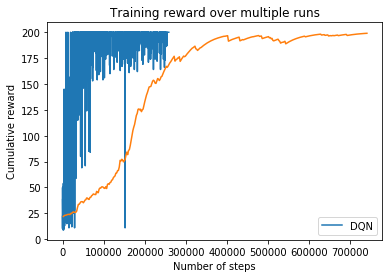

In [21]:
plt.figure()

#out = numpy_ewma_vectorized_v2(np.array(running_rewards_DQN),20)
#plt.plot(step_list_ddpg, out) # or 
plt.plot(step_list_DQN, running_rewards_DQN)
plt.title('Training reward over multiple runs')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
#plt.legend(['DDPG', 'REINFORCE']) #or 
plt.legend(['DQN', 'REINFORCE'])
plt.plot(step_list_reinforce, avg_rewards_reinforce)

plt.show()